In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Action:
    def __init__(self, reward_parameters=None):
        if reward_parameters:
            assert(isinstance(reward_parameters, tuple))
            assert(len(reward_parameters) == 2)
        else:
            reward_parameters = np.random.normal(), np.random.uniform()
        self._mean = reward_parameters[0]
        self._deviation = reward_parameters[1]

    def reward(self):
        return np.random.normal(self._mean, self._deviation)


class Bandit:
    def __init__(self):
        self._actions = list()
        
    @property
    def actions(self):
        return self._actions
    
    def reward(self, index):
        try:
            action = self.actions[index]
            return action.reward()
        except IndexError:
            return -100

In [3]:
bandit = Bandit()
for k in range(10):
    bandit.actions.append(Action())

In [4]:
number_of_actions = len(bandit.actions)
for k in range(10):
    action = np.random.randint(number_of_actions)
    print(f'{action:>4d} {bandit.reward(action):>3.6f}')

   2 -0.954731
   9 -2.038721
   5 1.489102
   0 1.010357
   5 1.523158
   6 0.531183
   6 0.117989
   9 -0.797331
   0 0.840030
   0 1.169151


In [5]:
def simple_bandit_algorithm(bandit, epsilon=0.01, Qa0=0.0, iterations=2000):
    number_of_actions = len(bandit.actions)
    Qa = np.full(shape=number_of_actions, fill_value=Qa0)
    Na = np.zeros(shape=number_of_actions, dtype=np.int)
    Qa_story = np.zeros(shape=(number_of_actions, iterations), dtype=np.float)
    threshold = 1.0 - epsilon
    for i in range(iterations):
        if np.random.uniform() < threshold:
            action = Qa.argmax()
        else:
            action = np.random.randint(number_of_actions)
        reward = bandit.reward(action)
        Na[action] += 1
        Qa[action] += (reward - Qa[action]) / Na[action]
        Qa_story[:, i] = Qa
    n = np.linspace(0, iterations-1, iterations, dtype=np.int)
    return Qa, Na, Qa_story, n

In [6]:
Qa, Na, Qa_story, n = simple_bandit_algorithm(bandit, epsilon=0.1)

In [7]:
Qa

array([ 1.08880873, -0.73595847, -1.1971034 ,  0.29722733,  2.10792476,
        1.48191053,  0.25721017, -0.19278503, -0.84061244, -0.93736779])

In [8]:
Na

array([  16,   14,    9,   33, 1824,   22,   16,   24,   16,   26])

In [9]:
for k, a in enumerate(bandit.actions):
    print(f'{k:>3d} {a._mean:>25.20f} {a._deviation:>25.20f}')

  0    1.07423490663552501090    0.15539920443613464140
  1   -0.74626454306059475385    0.17107358103700587293
  2   -1.08308741430177857268    0.16641151352801064611
  3    0.27835560924755581302    0.22030961160495066142
  4    2.08049086946309680357    0.59215992178126730661
  5    1.49962082174947997082    0.07048298770254779466
  6    0.22069648668953892323    0.37065618002728184521
  7   -0.05994314303089210566    0.68873713011067450029
  8   -0.54710568694469563500    0.81792774234852150261
  9   -0.89771189747376856083    0.78677366072641341521


In [10]:
Qa_1, Na_1, Qa_story_1, n_1 = simple_bandit_algorithm(bandit, epsilon=0.1)
Qa_2, Na_2, Qa_story_2, n_2 = simple_bandit_algorithm(bandit, epsilon=0.1, Qa0=5.0)

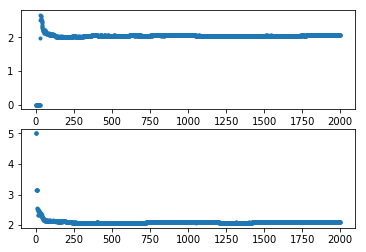

In [11]:
plt.clf()
best_action_1 = Qa_1.argmax()
best_action_2 = Qa_2.argmax()
plt.subplot(2,1,1)
plt.plot(n_1, Qa_story_1[best_action_1,:], '.')
plt.subplot(2,1,2)
plt.plot(n_2, Qa_story_2[best_action_2,:], '.')
plt.show()

In [12]:
best_action_1, best_action_2

(4, 4)

In [13]:
def weighted_bandit_algorithm(bandit, epsilon=0.01, Qa0=0.0, alpha=0.1, iterations=2000):
    number_of_actions = len(bandit.actions)
    Qa = np.full(shape=number_of_actions, fill_value=Qa0)
    Na = np.zeros(shape=number_of_actions, dtype=np.int)
    Qa_story = np.zeros(shape=(number_of_actions, iterations), dtype=np.float)
    threshold = 1.0 - epsilon
    for i in range(iterations):
        if np.random.uniform() < threshold:
            action = Qa.argmax()
        else:
            action = np.random.randint(number_of_actions)
        reward = bandit.reward(action)
        Na[action] += 1
        Qa[action] += (reward - Qa[action]) * alpha
        Qa_story[:, i] = Qa
    n = np.linspace(0, iterations-1, iterations, dtype=np.int)
    return Qa, Na, Qa_story, n

In [20]:
Qa_1, Na_1, Qa_story_1, n_1 = simple_bandit_algorithm(bandit, epsilon=0.1)
Qa_2, Na_2, Qa_story_2, n_2 = weighted_bandit_algorithm(bandit, epsilon=0.2, alpha=0.1)

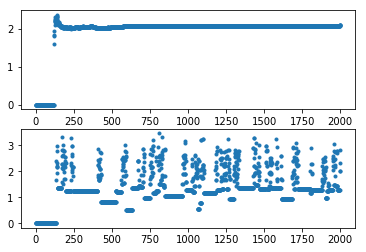

In [15]:
plt.clf()
best_action_1 = Qa_1.argmax()
best_action_2 = Qa_2.argmax()
plt.subplot(2,1,1)
plt.plot(n_1, Qa_story_1[best_action_1,:], '.')
plt.subplot(2,1,2)
plt.plot(n_2, Qa_story_2[best_action_2,:], '.')
plt.show()

In [16]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
def gradient_bandit_algorithm(bandit, epsilon=0.01, Qa0=0.0, alpha=0.1, n=None):
    iterations = 2000
    if len(n):
        assert(isinstance(n, np.ndarray))
        iterations = len(n)
    else:
        n = np.linspace(0, iterations-1, iterations, dtype=np.int)
    number_of_actions = len(bandit.actions)
    Ha = np.full(shape=number_of_actions, fill_value=Qa0)
    Qa = softmax(Ha) 
    Na = np.zeros(shape=number_of_actions, dtype=np.int)
    Qa_story = np.zeros(shape=(number_of_actions, iterations), dtype=np.float)
    threshold = 1.0 - epsilon
    reward_mean = 0.0
    for i in range(iterations):
        if np.random.uniform() < threshold:
            action = Qa.argmax()
        else:
            action = np.random.randint(number_of_actions)
        reward = bandit.reward(action)
        reward_mean += (reward - reward_mean) / (i + 1)
        Na[action] += 1
        delta = alpha * (reward - reward_mean)
        Ha -= delta * Qa
        Ha[action] += delta
        Qa = softmax(Ha)
        Qa_story[:, i] = Qa

    return Qa, Na, Qa_story
    

In [17]:
Qa_3, Na_3, Qa_story_3 = gradient_bandit_algorithm(bandit, epsilon=0.2, alpha=0.9, n=n_2)

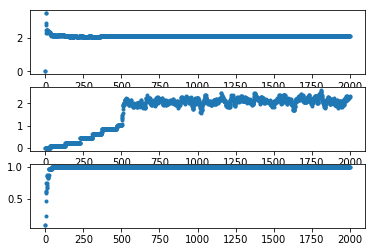

In [21]:
plt.clf()
best_action_1 = Qa_1.argmax()
best_action_2 = Qa_2.argmax()
best_action_3 = Qa_3.argmax()
plt.subplot(3,1,1)
plt.plot(n_1, Qa_story_1[best_action_1,:], '.')
plt.subplot(3,1,2)
plt.plot(n_2, Qa_story_2[best_action_2,:], '.')
plt.subplot(3,1,3)
plt.plot(n, Qa_story_3[best_action_3,:], '.')
plt.show()

In [19]:
best_action_1, best_action_2, best_action_3

(4, 4, 4)